In [3]:
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import seaborn as sns
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy
import math
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from random import sample
from sklearn.decomposition import PCA
from ordered_set import OrderedSet
from mpl_toolkits.axes_grid1 import make_axes_locatable
dats_mod=["CFSR","MERRA","ERA","JRA"]
#dats_mod2=["CMCC-CESM","CMCC-CM","CNRM-CM5",
#          "CanESM2","GFDL-CM3","GFDL-ESM2M",
          #"HadCM3","HadGEM2-CC","IPSL-CM5A",
#           "IPSL-CM5A",
#          "MIROC-ESM","MIROC5","MPI-ESM-MR",
#          "MRI-CGCM3","MRI-ESM1","NorESM1-M"]

dats_mod2=["CMCC-CM","MRI-CGCM3","MRI-ESM1",
          "MIROC5","CNRM-CM5","GFDL-ESM2M","MPI-ESM-MR",
          "NorESM1-M","IPSL-CM5A",
          "GFDL-CM3","CanESM2","MIROC-ESM","CMCC-CESM"]
dats_all = dats_mod + dats_mod2

dats_esm = ["MRI-ESM1","CNRM-CM5","GFDL-ESM2M",
           "MPI-ESM-MR","NorESM1-M","IPSL-CM5A",
           "CanESM2","MIROC-ESM","CMCC-CESM"]
dats_aog = ["CMCC-CM","MRI-CGCM3","MIROC5","GFDL-CM3"]


base_dir="/global/cscratch1/sd/marielp"
base_dir2="/global/cscratch1/sd/marielp/CMIP6"

In [4]:
#Function to find the mean/sd of each variable in the specified list and normalize the variables
def find_mean_sd(vlist,allframe,reg_str,sstr):
    dict_stats={'region':reg_str,'season':sstr}
    for v in vlist:
        dict_temp={}
        dict_temp['mean'] = allframe[v].mean()
        dict_temp['sd'] = allframe[v].std()
        dict_stats[v] = dict_temp
    return(dict_stats)

#Now a function for reading in the stats
def read_summ_stats(reg_str,sstr,dataset,vlist,modtype):
    basedir="/global/cscratch1/sd/marielp"
    summ_frame=pd.DataFrame()
    all_frame=pd.DataFrame()
    for d in dataset:
        fname_summ="{:}/{:}/STATS_SUMM/{:}_{:}_{:}_summtable.csv".format(basedir,d,d,sstr,reg_str)
        fname_tot="{:}/{:}/STATS_SUMM/{:}_{:}_{:}_indicestable.csv".format(basedir,d,d,sstr,reg_str)

        dcurr=sorted(glob.glob("{:}/{:}/BLOBS_NOREGIONAL/*DJF_blobs_noregional.nc".format(base_dir,d)))[0]
        d_mf = xa.open_dataset(dcurr)
        
        summ_sub=pd.read_csv(fname_summ)
        summ_sub['region']=reg_str
        summ_sub['season']=sstr
        summ_sub['mean_area']=summ_sub['mean_area_km']/(10**6)
        summ_sub['abs_centlat']=abs(summ_sub['mean_centlat'])
        tot_sub=pd.read_csv(fname_tot)
        
        all_frame = all_frame.append(summ_sub)
        
        d_dict={}
        d_dict['var']=d
        d_dict['region']=reg_str
        d_dict['season']=sstr
        d_dict['latres']=d_mf['lat'].values[1]-d_mf['lat'].values[0]
        d_dict['lonres']=d_mf['lon'].values[1]-d_mf['lon'].values[0]
        d_dict['# Features']=len(summ_sub)
        d_dict['Merged']=len(summ_sub[summ_sub['merged']=='YES'])
        d_dict['Duration']=summ_sub['duration_days'].mean()
        d_dict['Days/season']=len(list(set(tot_sub['time'])))/len(list(set(tot_sub['year'])))
        d_dict['Lat']=summ_sub['mean_centlat'].mean()
        d_dict['Size']=tot_sub['area_km'].mean()/(10**6)
        d_dict['Speed']=summ_sub['zonal_speed_km'].mean()
        d_dict['AI']=summ_sub['mean_AI'].mean()
        d_dict['BI']=summ_sub['mean_BI'].mean()
        summ_frame=summ_frame.append(d_dict,ignore_index=True)
        
    colnames_tab=d_dict.keys()
    keys_list =list(colnames_tab)[3:]
    summ_frame=summ_frame[colnames_tab]
    mean_dict={}
    mean_dict['var'] = 'Mean'
    mean_dict['region'] = reg_str
    mean_dict['season'] = sstr
    for k in keys_list:
        mean_dict[k]=summ_frame[k].mean()

    summ_frame_sort=summ_frame.sort_values(by=['latres','lonres'])
    summ_frame_sort = summ_frame_sort.append(mean_dict,ignore_index=True)
    norms_dict = find_mean_sd(vlist,all_frame,reg_str,sstr)
    summ_frame['model'] = modtype
    all_frame['model'] = modtype
    summ_frame_sort['model'] = modtype
    
    return({'SUMM':summ_frame, 'ALL':all_frame, 'SORT':summ_frame_sort,'MEAN_SD':norms_dict,'MODTYPE':modtype})

In [44]:
summ_all = pd.DataFrame()
all_all = pd.DataFrame()
sort_all = pd.DataFrame()
norm_vals = {}
norm_mod_vals={}
norm_all = pd.DataFrame()
var_str=['duration_days',
 'abs_centlat',
 'mean_area',
         'zonal_dist_km',
 'zonal_speed_km',
 'mean_AI',
 'mean_BI']

for r in ["NH","SH"]:
    for s in ["JJA","DJF"]:
        #Read in the reanalysis data and model data
        rean_temp = read_summ_stats(r,s,dats_mod,var_str,'rean')
        model_temp = read_summ_stats(r,s,dats_mod2,var_str,'model')
        summ_all = summ_all.append(rean_temp['SUMM'])
        summ_all = summ_all.append(model_temp['SUMM'])
        all_all = all_all.append(rean_temp['ALL'])
        all_all = all_all.append(model_temp['ALL'])
        sort_all = sort_all.append(rean_temp['SORT'])
        sort_all = sort_all.append(model_temp['SORT'])
        norm_vals['rean_{:}_{:}'.format(r,s)]=rean_temp['MEAN_SD']
        norm_mod_vals['model_{:}_{:}'.format(r,s)]=model_temp['MEAN_SD']
        #Normalize the data
        norm_frame = pd.DataFrame()
        norm_mframe = pd.DataFrame()
        norm_frame['var'] = rean_temp['ALL']['var']
        norm_mframe['var'] = model_temp['ALL']['var']
        for v in var_str:
            meanval = rean_temp['MEAN_SD'][v]['mean']
            sdval = rean_temp['MEAN_SD'][v]['sd']
            norm_frame[v] = (rean_temp['ALL'][v]-meanval)/sdval
            norm_mframe[v] = (model_temp['ALL'][v]-meanval)/sdval
        norm_frame['model'] = rean_temp['MODTYPE']
        norm_frame['region'] = r
        norm_frame['season'] = s
        norm_mframe['model'] = model_temp['MODTYPE']
        norm_mframe['region'] = r
        norm_mframe['season'] = s
        norm_all = norm_all.append(norm_frame)
        norm_all = norm_all.append(norm_mframe)
    


In [45]:
#Subset the data to only that of the NH Pacific
np_frame=all_all[(all_all['start_centlon']>=140) & (all_all['start_centlon']<=260) &
                 (all_all['end_centlon']>=140)& 
                 (all_all['end_centlon']<=260) & 
                 all_all['region'].str.match('NH')] 
np_frame['region']='NP'
sp_frame=all_all[(all_all['start_centlon']>=130) & (all_all['start_centlon']<=300) &
                 (all_all['end_centlon']>=130)& 
                 (all_all['end_centlon']<=300) & 
                 all_all['region'].str.match('SH')] 
sp_frame['region']='SP'


/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [46]:
p_frame=pd.concat([np_frame,sp_frame])

In [8]:
#Blocking frequency
avg_djf = xa.open_dataset('{:}/REAN_MODEL_MEANS_DJF.nc'.format(base_dir))
avg_jja = xa.open_dataset('{:}/REAN_MODEL_MEANS_JJA.nc'.format(base_dir))


In [9]:
#Z500 anomaly
adz_djf = xa.open_dataset('{:}/REAN_MODEL_MEAN_ADZ_DJF.nc'.format(base_dir))
adz_jja = xa.open_dataset('{:}/REAN_MODEL_MEAN_ADZ_JJA.nc'.format(base_dir))

In [10]:
#Z500 field
zg_djf = xa.open_dataset('{:}/REAN_MODEL_MEAN_Z500_DJF.nc'.format(base_dir))
zg_jja = xa.open_dataset('{:}/REAN_MODEL_MEAN_Z500_JJA.nc'.format(base_dir))

In [304]:
#Pearson correlation for reanalysis vs model
def corr_calc(bot_coord,top_coord,left_coord,right_coord,rean,mod):
    a_slice=mod.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord))
    r_slice=rean.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord))
    a_flat=np.ndarray.flatten(a_slice.values)
    r_flat=np.ndarray.flatten(r_slice.values)
    return(pearsonr(a_flat,r_flat))


#Implementing Gleckler relative error 
#Adding on the RMSE calculation for each region
def rmse_region(rean,mod,bot_coord,top_coord,left_coord,right_coord,normalize=False):
    r_slice=rean.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord))
    m_slice=mod.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord))
    diff_slice=m_slice-r_slice
    #maxmin=r_slice.values.max()-r_slice.values.min()
    iqr=np.quantile(r_slice.values,0.75)-np.quantile(r_slice.values,0.25)
    rmse = np.sqrt((diff_slice.values**2).mean())
    #print(rmse)
    if (normalize==False):
        rmse_out=rmse
    else:
        rmse_out=rmse/iqr
    #nrmse=rmse/maxmin
    return(rmse_out)

def calc_sig_rmse(rean,mod,bot_coord,top_coord,left_coord,right_coord):
    #Calculate the ref RMSE
    rref=rmse_region(rean,mod,bot_coord,top_coord,left_coord,right_coord)
    #Sample random set of points throughout the grid
    r_flat=np.ndarray.flatten(rean.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord)).values)
    m_flat=np.ndarray.flatten(mod.sel(lat=slice(bot_coord,top_coord),lon=slice(left_coord,right_coord)).values)
    npts=len(r_flat)
    rstore=np.zeros(1000)
    for n in range(1000):
        inds=np.random.randint(npts,size=int(npts/4))
        rsamp=r_flat[inds]
        msamp=m_flat[inds]
        #Permute the model sample
        mperm=np.random.choice(msamp,replace=False)
        dsamp=mperm-rsamp
        rr=np.sqrt((dsamp**2).mean())
        rstore[n]=rr
    #Is the ref on the left or the right?
    if (rref>=np.median(rstore)):
        ncount=len(rstore[rstore>=rref])
    else:
        ncount=len(rstore[rstore<=rref])
    pval=ncount/1000
    return(pval)



        

In [213]:
#corr_calc(25,75,140,260,avg_jja['reanBlockMean_WGT'],avg_jja['modelBlockMean_WGT'])
#corr_calc(-75,-25,130,300,avg_jja['reanBlockMean_WGT'],avg_jja['modelBlockMean_WGT'])
corr_calc(25,75,140,260,avg_djf['reanBlockMean_WGT'],avg_djf['modelBlockMean_WGT'])
corr_calc(-75,-25,130,300,avg_djf['reanBlockMean_WGT'],avg_djf['modelBlockMean_WGT'])


(0.8867394390282634, 0.0)

In [270]:
#Calculate the RMSE for each model vs the reanalysis
def calc_rmse_metric(mod_list,avg_set,reg,s,varname_r,varname_m,b,t,l,r,metname,output_dataframe,comparemet='median'):
    rean_var=avg_set[varname_r]
    store_rmse={"Region":reg,"Season":s,"Metric":metname,'valtype':'RMSE'}
    store_pval={"Region":reg,"Season":s,"Metric":metname,'valtype':'P Value'}
    list_rmse=[]
    
    #Calculate the RMSE for each model and store it
    for d in mod_list:
        mod_var=avg_set[d]
        rmse_dat=rmse_region(rean_var,mod_var,b,t,l,r,normalize=True)

        list_rmse+=[rmse_dat]
        if (comparemet!='median'):
            store_rmse[d]=rmse_dat
            store_pval[d]=calc_sig_rmse(rean_var,mod_var,b,t,l,r)
    if (comparemet=='median'):
        #What is the median rmse for this?
        rmse_median=np.percentile(list_rmse,50)

        for d in mod_list:
            mod_var=avg_set[d]
            rmse_dat=rmse_region(rean_var,mod_var,b,t,l,r,normalize=True)
            dat_rel=(rmse_dat-rmse_median)/rmse_median
            store_rmse[d]=dat_rel

    #Calculate relative rmse for the model average
    mod_var=avg_set[varname_m]
    rmse_mod=rmse_region(rean_var,mod_var,b,t,l,r,normalize=True)
    if (comparemet=='median'):
        mod_rel=(rmse_mod-rmse_median)/rmse_median
        store_rmse['Model_avg']=mod_rel
    else:
        store_rmse['Model_avg']=rmse_mod
        store_pval['Model_avg']=calc_sig_rmse(rean_var,mod_var,b,t,l,r)

    output_dataframe=output_dataframe.append(store_rmse,ignore_index=True)
    if (comparemet!='median'):
        output_dataframe=output_dataframe.append(store_pval,ignore_index=True)
    col_order=['Region','Season','Metric','valtype','Model_avg']+mod_list
    return(output_dataframe)

In [289]:
#Compare two histograms (relative frequency)
#SUM OF HISTOGRAMS: Max would be 2 (if they were on top of each other), min would be 1

def calc_optimal_bins(rean,vmin,vmax):
    binned_rean,binrange=np.histogram(np.clip(rean,vmin,vmax),range=(vmin,vmax),bins='doane')
    #we don't want any bins with 0...
    nbins=len(binrange)
    if (np.min(binned_rean)<0.00000001):
        while(np.min(binned_rean)<0.00000001):
            nbins-=1
            binned_rean,binrange=np.histogram(np.clip(rean,vmin,vmax),range=(vmin,vmax),bins=nbins)
    return(binrange)
            
    

def histogram_diffs(rean,model,vmin,vmax,normalize=False):
    bincalc=calc_optimal_bins(rean,vmin,vmax)
    binned_rean,binrange=np.histogram(np.clip(rean,vmin,vmax),bins=bincalc)     
    binned_model,modelbin=np.histogram(np.clip(model,vmin,vmax),bins=bincalc)
    #print(binned_rean)
    #print(np.sum(binned_rean),len(rean))
    #print(np.sum(binned_model),len(model))
    #print(binned_model)
    rean_dens=binned_rean/len(rean)
    model_dens=binned_model/len(model)
    k=kruskal(rean,model)

    #maxmin=np.max(rean_dens)-np.min(rean_dens)
    #print(rean_dens)
    #print(model_dens)
    iqr=np.quantile(rean_dens,0.75)-np.quantile(rean_dens,0.25)
    #print(maxmin,iqr)
    #print(np.quantile(rean_dens,0.75),np.quantile(rean_dens,0.25),iqr)
    diff_bins_sq=(model_dens-rean_dens)**2
    root_diff=np.sqrt(diff_bins_sq.mean())
    #print(root_diff)
    if (normalize==False):
        diff_out=root_diff
    else:
        diff_out=root_diff/iqr
    #print(root_diff,maxmin,diff_out)
    #print(diff_out)
    return(diff_out,k.pvalue)

#Compare models to the median model 
def calc_rmse_distr(mod_list,r,s,metname,input_frame,output_dataframe,comparemet='median'):
    store_rmse={"Region":r,"Season":s,"Metric":metname,"valtype":"RMSE"}
    store_pval={"Region":r,"Season":s,"Metric":metname,"valtype":"P Value"}
    frame_sub=input_frame[input_frame['region'].str.match(r)&input_frame['season'].str.match(s)]
    frame_r=frame_sub[frame_sub['model'].str.match('rean')]
    var_r=frame_r[metname]
    vmin=math.floor(np.percentile(var_r,5))
    vmax=math.ceil(np.percentile(var_r,95))

    frame_m=frame_sub[frame_sub['model'].str.match('model')]
    list_rmse=[]
    #Calculate the RMSE for each model and store it
    for d in mod_list:
        frame_indiv=frame_sub[frame_sub['var'].str.match(d)]
        var_m=frame_indiv[metname]
        #rmse_dat=rmse_distributions(var_r,var_m)
        rmse_dat,pval=histogram_diffs(var_r,var_m,vmin,vmax,normalize=True)
        list_rmse+=[rmse_dat]
        if (comparemet!='median'):
            store_rmse[d]=rmse_dat
            store_pval[d]=pval
    if (comparemet=='median'):
        #What is the median rmse for this?
        rmse_median=np.percentile(list_rmse,50)
        for d in mod_list:
            frame_indiv=frame_sub[frame_sub['var'].str.match(d)]
            var_m=frame_indiv[metname]
            #rmse_dat=rmse_distributions(var_r,var_m)
            rmse_dat,pval=histogram_diffs(var_r,var_m,vmin,vmax,normalize=True)
            dat_rel=(rmse_dat-rmse_median)/rmse_median
            store_rmse[d]=dat_rel

    #Calculate relative rmse for the model average
    var_m=frame_m[metname]
    rmse_mod,pval=histogram_diffs(var_r,var_m,vmin,vmax,normalize=True)
    #rmse_mod=rmse_distributions(var_r,var_m)
    if (comparemet=='median'):
        mod_rel=(rmse_mod-rmse_median)/rmse_median
        store_rmse['Model_avg']=mod_rel
    else:
        store_rmse['Model_avg']=rmse_mod
        store_pval['Model_avg']=pval

    output_dataframe=output_dataframe.append(store_rmse,ignore_index=True)
    if (comparemet!='median'):
        output_dataframe=output_dataframe.append(store_pval,ignore_index=True)
    col_order=['Region','Season','Metric','valtype','Model_avg']+mod_list

    output_dataframe=output_dataframe[col_order]
    return(output_dataframe)

In [276]:
metrics_relative=pd.DataFrame()
#Doing this only for the North Hemisphere Pacific 140-260 and South Hemisphere Pacific 130-300
#Blocking Frequency, relative
metrics_relative=calc_rmse_metric(dats_mod2,avg_jja,'NP','JJA','reanBlockMean','modelBlockMean',25,75,140,260,'RMSE Freq',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,avg_jja,'SP','JJA','reanBlockMean','modelBlockMean',-75,-25,130,300,'RMSE Freq',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,avg_djf,'NP','DJF','reanBlockMean','modelBlockMean',25,75,140,260,'RMSE Freq',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,avg_djf,'SP','DJF','reanBlockMean','modelBlockMean',-75,-25,130,300,'RMSE Freq',metrics_relative)

#Z500, relative
metrics_relative=calc_rmse_metric(dats_mod2,zg_jja,'NP','JJA','reanMean','modelMean',25,75,140,260,'RMSE Z500',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,zg_jja,'SP','JJA','reanMean','modelMean',-75,-25,130,300,'RMSE Z500',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,zg_djf,'NP','DJF','reanMean','modelMean',25,75,140,260,'RMSE Z500',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,zg_djf,'SP','DJF','reanMean','modelMean',-75,-25,130,300,'RMSE Z500',metrics_relative)

#anomaly, relative
metrics_relative=calc_rmse_metric(dats_mod2,adz_jja,'NP','JJA','reanMean','modelMean',25,75,140,260,'RMSE ADZ',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,adz_jja,'SP','JJA','reanMean','modelMean',-75,-25,130,300,'RMSE ADZ',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,adz_djf,'NP','DJF','reanMean','modelMean',25,75,140,260,'RMSE ADZ',metrics_relative)
metrics_relative=calc_rmse_metric(dats_mod2,adz_djf,'SP','DJF','reanMean','modelMean',-75,-25,130,300,'RMSE ADZ',metrics_relative)

var_str=['duration_days',
'abs_centlat',
'mean_area',
         'zonal_dist_km',
'zonal_speed_km',
'mean_AI',
'mean_BI']

for r in ['NP','SP']:
   for s in ['JJA','DJF']:
       for v in var_str:
           metrics_relative=calc_rmse_distr(dats_mod2,r,s,v,p_frame,metrics_relative)

metrics_relative=metrics_relative.drop(['valtype'],axis=1)

# #Blocking Frequency, relative
# metrics_relative=calc_rmse_metric(dats_mod2,avg_jja,'NH','JJA','reanBlockMean','modelBlockMean',25,75'RMSE Freq',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,avg_jja,'SH','JJA','reanBlockMean','modelBlockMean',-75,-25,'RMSE Freq',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,avg_djf,'NH','DJF','reanBlockMean','modelBlockMean',25,75,'RMSE Freq',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,avg_djf,'SH','DJF','reanBlockMean','modelBlockMean',-75,-25,'RMSE Freq',metrics_relative)

# #Z500, relative
# metrics_relative=calc_rmse_metric(dats_mod2,zg_jja,'NH','JJA','reanMean','modelMean',25,75,'RMSE Z500',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,zg_jja,'SH','JJA','reanMean','modelMean',-75,-25,'RMSE Z500',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,zg_djf,'NH','DJF','reanMean','modelMean',25,75,'RMSE Z500',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,zg_djf,'SH','DJF','reanMean','modelMean',-75,-25,'RMSE Z500',metrics_relative)

# #anomaly, relative
# metrics_relative=calc_rmse_metric(dats_mod2,adz_jja,'NH','JJA','reanMean','modelMean',25,75,'RMSE ADZ',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,adz_jja,'SH','JJA','reanMean','modelMean',-75,-25,'RMSE ADZ',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,adz_djf,'NH','DJF','reanMean','modelMean',25,75,'RMSE ADZ',metrics_relative)
# metrics_relative=calc_rmse_metric(dats_mod2,adz_djf,'SH','DJF','reanMean','modelMean',-75,-25,'RMSE ADZ',metrics_relative)

In [278]:
metrics_relative.to_csv("metrics_relative.csv",index=False)

In [315]:
def mk_metrics_plot(metrics_long,r,s,vmin,vmax,cmap,tstring,fstring,p_long=None):
    metrics_sub=metrics_long[metrics_long['Region'].str.match(r)&metrics_long['Season'].str.match(s)]    
    col_pivot=['Model_avg']+dats_mod2
    metrics_pivot=metrics_sub.pivot(index='Metric',columns='variable',values='value')
    metrics_pivot=metrics_pivot.reindex(col_pivot,axis=1)
    if p_long is not None:
        p_sub=p_long[p_long['Region'].str.match(r)&p_long['Season'].str.match(s)] 
        p_pivot=p_sub.pivot(index='Metric',columns='variable',values='annot')
        p_pivot=p_pivot.reindex(col_pivot,axis=1)
    #right_labs=[]
    #for i in metrics_pivot.index:
    #    mean_met=metrics_pivot.loc[i].mean()
    #    right_labs+=[str(mean_met)]
    #Make a dictionary of the 
    fig,ax=plt.subplots(figsize=(12,8))
    #ax2=ax.twinx()
    #ax2.set_yticks(right_labs)
    fig=sns.heatmap(metrics_pivot,ax=ax,cmap=cmap,center=0,vmin=vmin,vmax=vmax,linewidths=0.5,annot=p_pivot,fmt="").set_title(tstring)
    plt.savefig(fstring)

    
def mk_metrics_boxplot(metrics_long,r,s,var_list,rean_list,mod_list):
    metrics_sub=metrics_long[metrics_long['region'].str.match(r)&metrics_long['season'].str.match(s)]  
    for v in list(set(metrics_sub['variable'])):
        v_sub=metrics_sub[metrics_sub['variable'].str.match(v)]
        fig,ax=plt.subplots()
        rean_sub=v_sub[v_sub['model'].str.match('rean')]
        model_sub=v_sub[v_sub['model'].str.match('model')]
        for m in mod_list:
            m_sub=v_sub[v_sub['var'].str.match(m)]
            k=kruskal(rean_sub['value'],m_sub['value'])
            if (k.pvalue<0.1):
                #print(m,v,k.pvalue)
                linecol='red'
            else:
                linecol='grey'
            sns.kdeplot(m_sub['value'],color=linecol,alpha=0.3)
        for m in rean_list:
            m_sub=v_sub[v_sub['var'].str.match(m)]
            sns.kdeplot(m_sub['value'],color='blue',alpha=0.3)
        sns.kdeplot(rean_sub['value'],color='blue',linestyle='--')
        sns.kdeplot(model_sub['value'],color='black',linestyle='--')
        ax.set_title(v)
    #fig,ax=plt.subplots(figsize=(12,8))
    #ax2=ax.twinx()
    #ax2.set_yticks(right_labs)
    
  

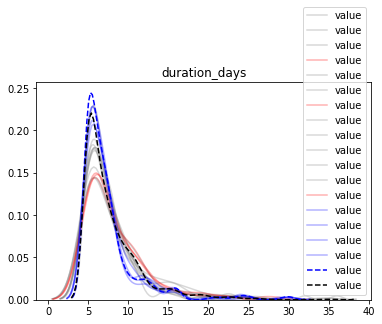

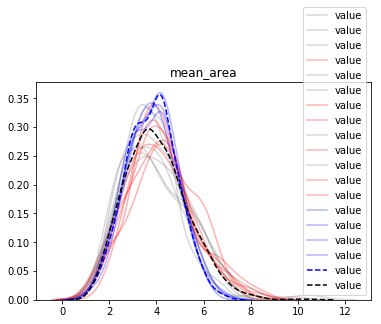

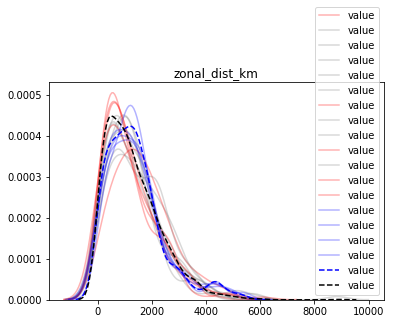

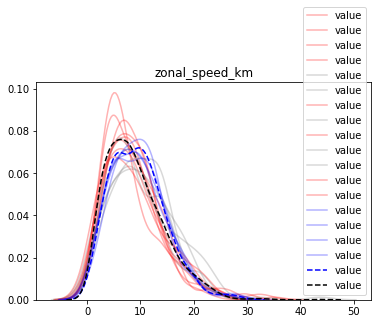

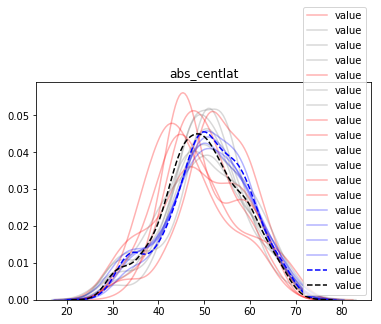

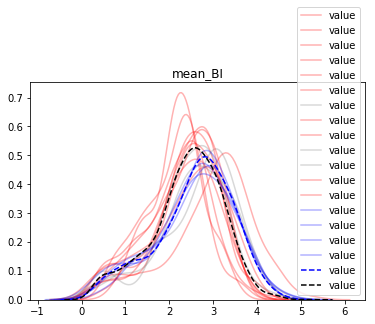

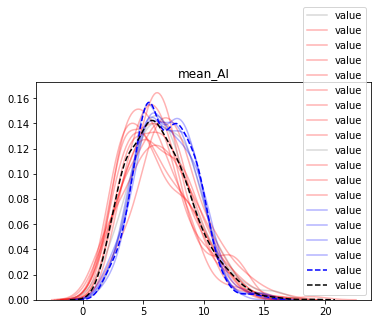

In [280]:
p_melt=p_frame[['region','season','var','model']+var_str].melt(id_vars=['region','season','var','model'])
mk_metrics_boxplot(p_melt,'SP','DJF',var_str,dats_mod,dats_mod2)

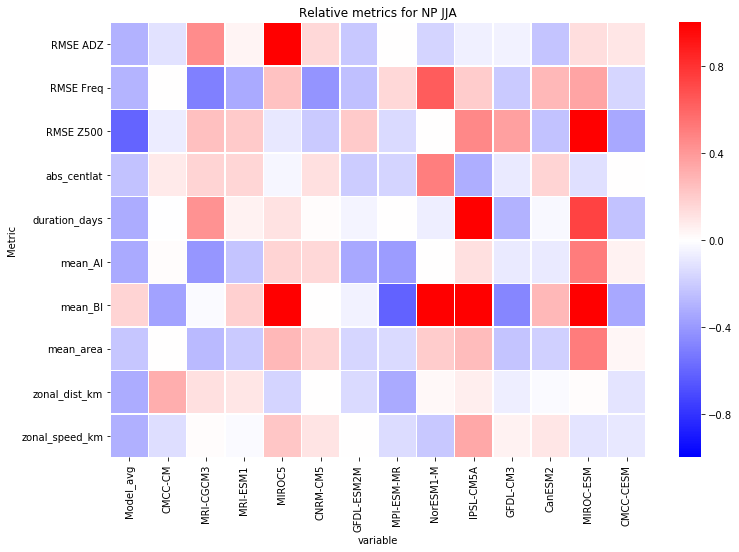

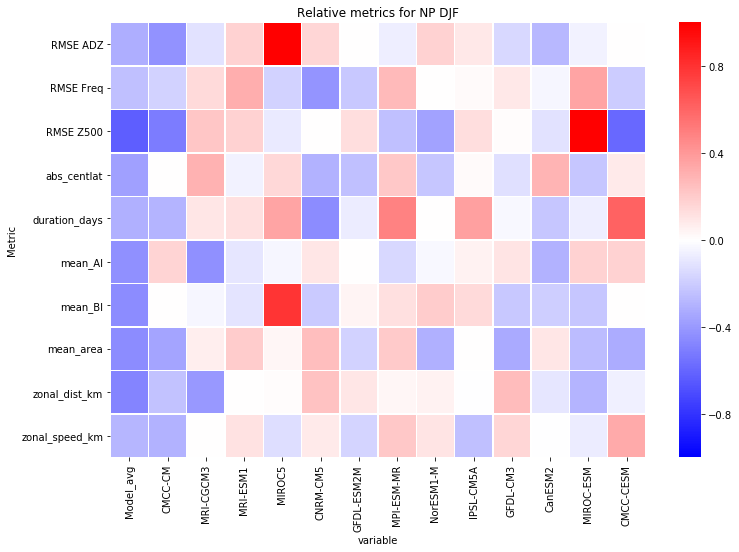

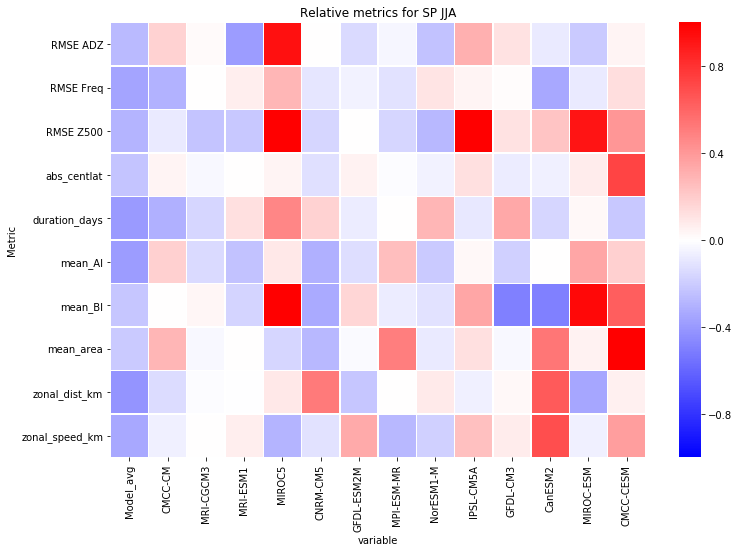

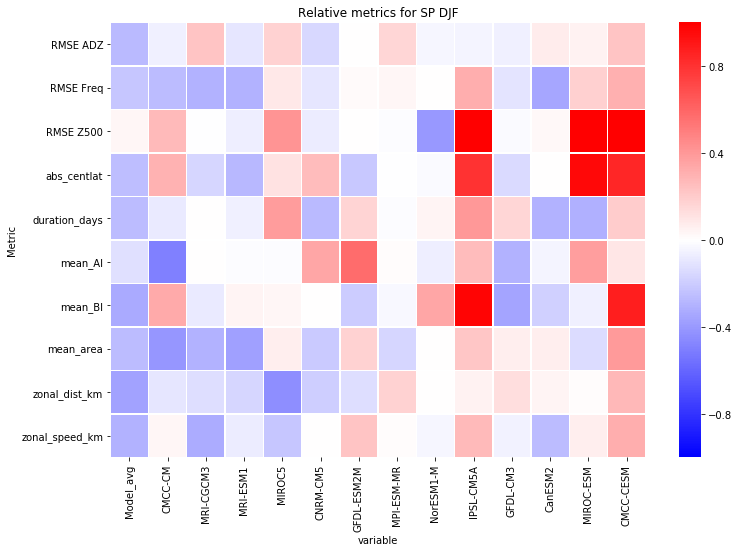

In [51]:
metrics_relative=pd.read_csv("metrics_relative.csv")
metrics_long=pd.melt(metrics_relative,id_vars=['Region','Season','Metric'])

for r in ['NP','SP']:
    for s in ['JJA','DJF']:
        tstring="Relative metrics for {:} {:}".format(r,s)
        fstring='{:}_{:}_relative.png'.format(r,s)
        mk_metrics_plot(metrics_long,r,s,-1,1,'bwr',tstring,fstring)
#mk_metrics_plot(metrics_long,"NH","JJA",-0.75,0.75,'bwr')
#mk_metrics_plot(metrics_long,"NH","DJF",-0.75,0.75,'bwr')
#mk_metrics_plot(metrics_long,"SH","JJA",-0.75,0.75,'bwr')
#mk_metrics_plot(metrics_long,"SH","DJF",-0.75,0.75,'bwr',tstring)


In [305]:
#Do the same thing for the absolute metrics
metrics_absolute=pd.DataFrame()
#Blocking Frequency, absolute
metrics_absolute=calc_rmse_metric(dats_mod2,avg_jja,'NP','JJA','reanBlockMean','modelBlockMean',25,75,140,260,'RMSE Freq',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,avg_jja,'SP','JJA','reanBlockMean','modelBlockMean',-75,-25,130,300,'RMSE Freq',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,avg_djf,'NP','DJF','reanBlockMean','modelBlockMean',25,75,140,260,'RMSE Freq',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,avg_djf,'SP','DJF','reanBlockMean','modelBlockMean',-75,-25,130,300,'RMSE Freq',metrics_absolute,comparemet='absolute')
#Z500, absolute
metrics_absolute=calc_rmse_metric(dats_mod2,zg_jja,'NP','JJA','reanMean','modelMean',25,75,140,260,'RMSE Z500',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,zg_jja,'SP','JJA','reanMean','modelMean',-75,-25,130,300,'RMSE Z500',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,zg_djf,'NP','DJF','reanMean','modelMean',25,75,140,260,'RMSE Z500',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,zg_djf,'SP','DJF','reanMean','modelMean',-75,-25,130,300,'RMSE Z500',metrics_absolute,comparemet='absolute')
#anomlay, absolute
metrics_absolute=calc_rmse_metric(dats_mod2,adz_jja,'NP','JJA','reanMean','modelMean',25,75,140,260,'RMSE ADZ',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,adz_jja,'SP','JJA','reanMean','modelMean',-75,-25,130,300,'RMSE ADZ',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,adz_djf,'NP','DJF','reanMean','modelMean',25,75,140,260,'RMSE ADZ',metrics_absolute,comparemet='absolute')
metrics_absolute=calc_rmse_metric(dats_mod2,adz_djf,'SP','DJF','reanMean','modelMean',-75,-25,130,300,'RMSE ADZ',metrics_absolute,comparemet='absolute')


var_str=['duration_days',
 'abs_centlat',
 'mean_area',
         'zonal_dist_km',
 'zonal_speed_km',
 'mean_AI',
 'mean_BI']

for r in ['NP','SP']:
    for s in ['JJA','DJF']:
        for v in var_str:
            metrics_absolute=calc_rmse_distr(dats_mod2,r,s,v,p_frame,metrics_absolute,comparemet='absolute')

metrics_absolute.to_csv("metrics_absolute.csv",index=False)
# #Blocking Frequency, absolute
# metrics_absolute=calc_rmse_metric(dats_mod2,avg_jja,'NH','JJA','reanBlockMean','modelBlockMean',75,25,'RMSE Freq',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,avg_jja,'SH','JJA','reanBlockMean','modelBlockMean',-25,-75,'RMSE Freq',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,avg_djf,'NH','DJF','reanBlockMean','modelBlockMean',75,25,'RMSE Freq',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,avg_djf,'SH','DJF','reanBlockMean','modelBlockMean',-25,-75,'RMSE Freq',metrics_absolute,comparemet='absolute')
# #Z500, absolute
# metrics_absolute=calc_rmse_metric(dats_mod2,zg_jja,'NH','JJA','reanMean','modelMean',75,25,'RMSE Z500',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,zg_jja,'SH','JJA','reanMean','modelMean',-25,-75,'RMSE Z500',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,zg_djf,'NH','DJF','reanMean','modelMean',75,25,'RMSE Z500',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,zg_djf,'SH','DJF','reanMean','modelMean',-25,-75,'RMSE Z500',metrics_absolute,comparemet='absolute')
# #anomlay, absolute
# metrics_absolute=calc_rmse_metric(dats_mod2,az_jja,'NH','JJA','reanMean','modelMean',75,25,'RMSE ADZ',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,az_jja,'SH','JJA','reanMean','modelMean',-25,-75,'RMSE ADZ',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,az_djf,'NH','DJF','reanMean','modelMean',75,25,'RMSE ADZ',metrics_absolute,comparemet='absolute')
# metrics_absolute=calc_rmse_metric(dats_mod2,az_djf,'SH','DJF','reanMean','modelMean',-25,-75,'RMSE ADZ',metrics_absolute,comparemet='absolute')


# var_str=['duration_days',
#  'abs_centlat',
#  'mean_area',
#  'zonal_speed_km',
#  'mean_AI',
#  'mean_BI']

# for r in ['NH','SH']:
#     for s in ['JJA','DJF']:
#         for v in var_str:
#             metrics_absolute=calc_rmse_distr(dats_mod2,r,s,v,all_all,metrics_absolute,comparemet='absolute')

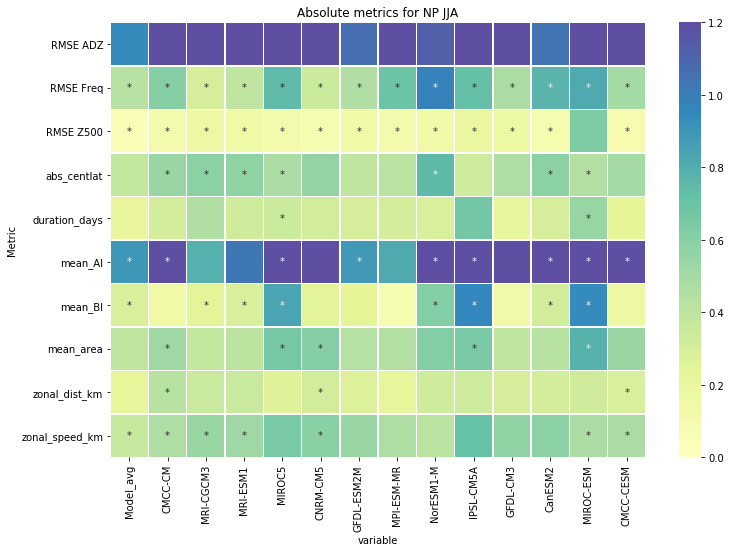

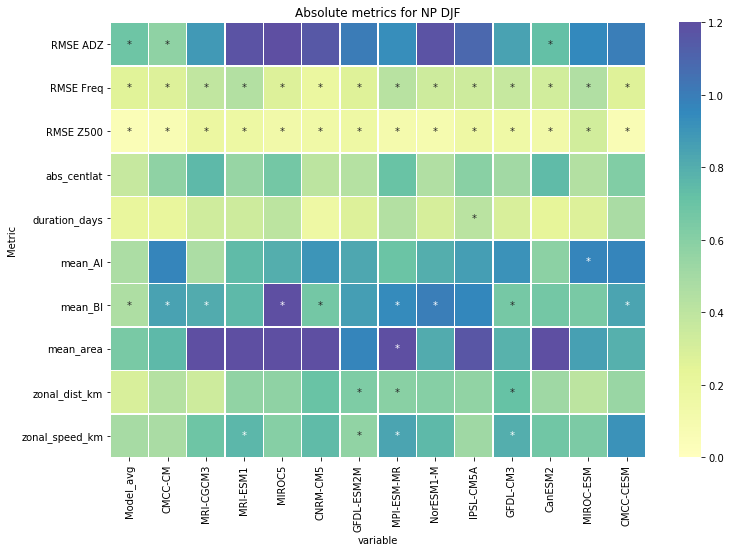

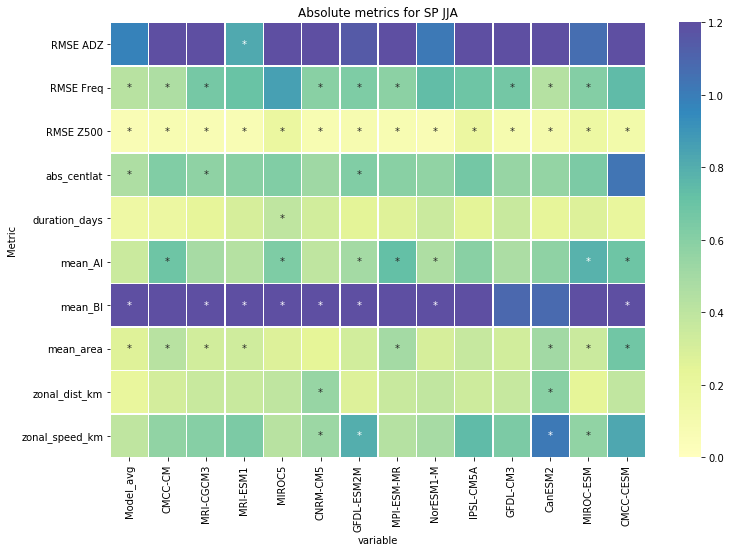

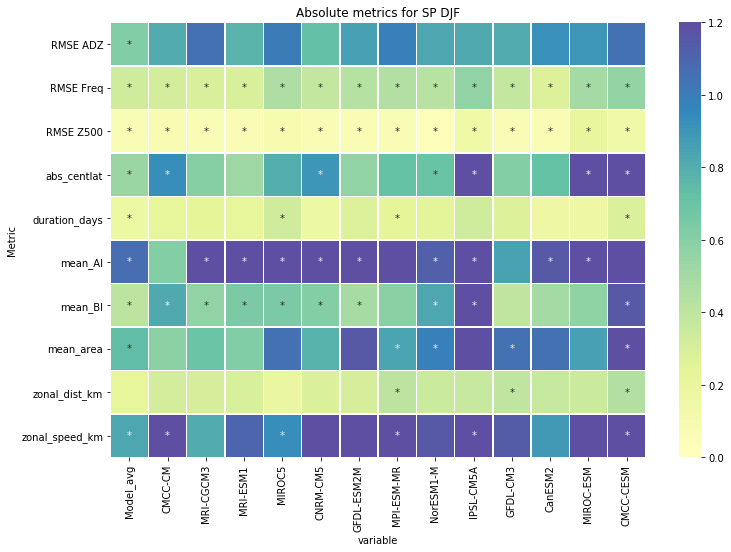

In [317]:
a_rmse=metrics_absolute[metrics_absolute['valtype'].str.match('RMSE')].drop(['valtype'],axis=1)
a_p=metrics_absolute[metrics_absolute['valtype'].str.match('P Value')].drop(['valtype'],axis=1)

metrics_long=pd.melt(a_rmse,id_vars=['Region','Season','Metric'])
p_long=pd.melt(a_p,id_vars=['Region','Season','Metric'])

p_long.loc[p_long['value']<=0.05,'annot']='*'
p_long.loc[p_long['value']>0.05,'annot']=""
p_long=p_long.drop(['value'],axis=1)
for r in ['NP','SP']:
    for s in ['JJA','DJF']:
        tstring="Absolute metrics for {:} {:}".format(r,s)
        fstring='{:}_{:}_absolute.png'.format(r,s)
        mk_metrics_plot(metrics_long,r,s,0,1.2,'Spectral',tstring,fstring,p_long)


In [76]:
metrics_sub=metrics_relative[metrics_relative['Region'].str.match('NP') & metrics_relative['Season'].str.match('DJF')].drop(columns=['Region','Season'],axis=1)
sub_melt=metrics_sub.melt(id_vars=['Metric'])

#sns.lineplot(data=sub_melt,x='RMSE Z500',y='mean_BI',)

# colnames=metrics_sub['Metric']
# metrics_t=metrics_sub[metrics_sub.columns[1:]].T
# metrics_t.columns=colnames
# c_metrics=metrics_t.corr()
# mask = np.zeros_like(c_metrics, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# #cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(c_metrics, mask=mask, cmap='bwr', center=0,vmin=-1,vmax=1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

,Metric,variable,value
0,RMSE Freq,Model_avg,-0.247425
1,RMSE Z500,Model_avg,-0.631467
2,RMSE ADZ,Model_avg,-0.314645
3,duration_days,Model_avg,-0.308470
4,abs_centlat,Model_avg,-0.367875
5,mean_area,Model_avg,-0.447594
6,zonal_speed_km,Model_avg,-0.283498
7,mean_AI,Model_avg,-0.431903
8,mean_BI,Model_avg,-0.449642
9,RMSE Freq,CMCC-CM,-0.177243


In [21]:
compare_table = pd.DataFrame()
cols=['region','season','var','corr','nrmse','corr_dist']
rean_v="reanBlockMean_WGT"
mm_v='modelBlockMean_WGT'

for r in ['NH','SH']:
    if r=='NH':
        tb=75
        bb=25
    else: 
        tb=-25
        bb=-75
    for s in ['JJA','DJF']:
        if s=='JJA':
            dat=avg_jja
        else:
            dat=avg_djf
        store_dict={}
        store_dict['region']=r
        store_dict['season']=s
        store_dict['var']='mean'
        store_dict['corr']=corr_calc(bb,tb,dat,rean_v,mm_v)[0]
        store_dict['corr_dist']=1-abs(store_dict['corr'])
        store_dict['nrmse']=rmse_region(dat[rean_v],dat[mm_v],bb,tb)
        compare_table = compare_table.append(store_dict,ignore_index=True)
        for d in dats_mod2:
            store_dict['var']=d
            mm_d = '{:}_WGT'.format(d)
            store_dict['corr']=corr_calc(bb,tb,dat,rean_v,mm_d)[0]
            store_dict['corr_dist']=1-abs(store_dict['corr'])
            store_dict['nrmse']=rmse_region(dat[rean_v],dat[mm_d],bb,tb)
            compare_table=compare_table.append(store_dict,ignore_index=True)
compare_table=compare_table[cols]


NameError: name 'corr_calc' is not defined

In [ ]:
#So we have the means/sd for both reanalysis and models for each of the distributions
#We also have all of the z-scores (with respect to the reanalysis mean)
#What would we output for the stoplight diagram?
#For now we'll do means for the MMM as well as each model

def output_mean_z_scores(input_data,mean_sd,rean_list,mod_list,vlist,vfmt,r,s,outname):
    store_frame=pd.DataFrame()

    #multi model mean
    store_dict={}
    knum=len(vlist)+1
    klist=[None]*knum
    klist[0]='model'
    colnames=[None]*knum
    colnames[0]='model'

    #Get the dictionary with the proper region values
    mean_dict=mean_sd['rean_{:}_{:}'.format(r,s)]
    
    #Multi-reananalysis mean
    store_dict['model']='Multi-rean mean'
    rean_data=input_data[input_data['model'].str.match('rean')&input_data['region'].str.match(r)&input_data['season'].str.match(s)]
    
    j=1
    for v in vlist:
        klist[j]=v
        vname=vfmt[j-1]
        mval=mean_dict[v]['mean']
        colnames[j]='{:}={:.2f}'.format(vname,mval)
        x=rean_data[v].mean()
        store_dict[v]=x
        j+=1   
    store_frame=store_frame.append(store_dict,ignore_index=True)

    #Now repeat for each of the models
    for d in rean_list:
        store_dict={}
        store_dict['model']=d
        model_data=input_data[input_data['var'].str.match(d)&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

        for v in vlist:
            vname=v
            x=model_data[v].mean()
            store_dict[vname]=x
        store_frame=store_frame.append(store_dict,ignore_index=True)

    
    #Multi-model mean
    store_dict={}
    store_dict['model']='Multi-model mean'
    model_data=input_data[input_data['model'].str.match('model')&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

    for v in vlist:
        x=model_data[v].mean()
        store_dict[v]=x
    store_frame = store_frame.append(store_dict,ignore_index=True)

    #Now repeat for each of the models
    for d in mod_list:
        store_dict={}
        store_dict['model']=d

        model_data=input_data[input_data['var'].str.match(d)&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

        for v in vlist:
            vname=v
            x=model_data[v].mean()
            store_dict[vname]=x
        store_frame=store_frame.append(store_dict,ignore_index=True)
    store_frame=store_frame[klist]
    store_frame.columns=colnames
    store_frame.to_csv(outname,index=False)



In [ ]:
var_str=['duration_days',
 'abs_centlat',
 'mean_area',
 'zonal_speed_km',
 'mean_AI',
 'mean_BI']
var_fmt=['BD','CL','BA','BS','AI','BI']

for r in ['NH','SH']:
    for s in ['DJF','JJA']:
        sname='~/model_mean_diff_{:}_{:}.csv'.format(r,s)
        output_mean_z_scores(norm_all,norm_vals,dats_mod,dats_mod2,var_str,var_fmt,r,s,sname)



In [ ]:
#Stats for reanalysis data
norm_rean = norm_all[norm_all['model'].str.match('rean')]
summ_rean = all_all[all_all['model'].str.match('rean')]
#for r in ['NH','SH']:
#    for s in ['JJA','DJF']:
#       for v in var_str:
#            var_sel = norm_rean[norm_rean['region'].str.match(r) & norm_rean['season'].str.match(s)][['var',v]]
#            x=[var_sel[var_sel["var"]==d][v] for d in dats_mod]
 #           print("results for {:} {:}, {:}".format(r,s,v))
 #           print(kruskal(*x))

for r in ['NH','SH']:
    for s in ['JJA','DJF']:
        for v in var_str:
            var_sel = summ_rean[summ_rean['region'].str.match(r) & summ_rean['season'].str.match(s)][['var',v]]
            x=[var_sel[var_sel['var']==d][v] for d in dats_mod]
            k=kruskal(*x)
            if k.pvalue<0.8:
                print("result for {:} ({:} {:}) is {:}".format(v,r,s,k))


In [ ]:
# #Mean/sd of each?
# norm_vals[['region','season','duration_days']]
# norm_copy = norm_vals
# for v in var_str:
#     norm_copy=pd.concat([norm_copy.drop([v],axis=1),norm_copy[v].apply(pd.Series)],axis=1)
# cols_old = norm_copy.columns
# print(cols_old)


In [ ]:
# for r in ['NH','SH']:
#     for s in ['JJA','DJF']:
#         norm_sub = norm_melt[norm_melt['region'].str.match(r) & norm_melt['season'].str.match(s)]
#         sns.catplot(data=norm_sub,col='variable',x='var',y='value',kind='box',hue='model')
# #sns.catplot(data=norm_melt,col='season',row='region',kind='box',x='variable',y='value',hue='model')
# #plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)

In [ ]:
# #Let's try some PCA shit
# pca = PCA(n_components=2)
# #Try training on reanalysis data
# data_train = norm_all[norm_all['model'].str.match('rean')][var_str]
# pca.fit(data_train)
# data_transform = pca.transform(data_train)
# data_test = norm_all[norm_all['model'].str.match('model')][var_str]
# data_transform_test = pca.transform(data_test)


In [ ]:
# print(pca.explained_variance_ratio_)
# print(pd.DataFrame(pca.components_,columns=var_str))